In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

In [3]:
df=pd.read_csv('../data/data_clean/SASS_cleaned_v1.csv', sep=',', header=0)
print(df.shape)
df.head()

(3640, 155)


,CNTLNUM_T,SCHCNTL,CNTLNUM_P,label_Current,age_T,earnings_total,earnings_school,base_salary_T,num_dependents,dependents_age5,...,incen_reten_english,incen_reten_soc_studies,incen_reten_STEM_comp_sci,incen_reten_STEM_math,incen_reten_STEM_phys_sci,incen_reten_STEM_biology,incen_reten_esl,incen_reten_foreign_lang,incen_reten_music_art,incen_reten_voc_ed
0,143668,100019,101276,0,3,3,3,4,4,0,...,0,0,0,0,0,0,1,0,0,1
1,147352,100029,103310,0,1,2,2,2,4,2,...,0,0,0,0,0,0,0,0,0,0
2,141414,100053,108866,0,3,4,3,4,4,0,...,0,0,0,0,0,0,0,0,0,0
3,131108,100056,102684,0,3,4,2,3,2,0,...,0,0,0,0,0,0,0,0,0,0
4,139862,100062,104721,0,3,3,3,3,1,0,...,0,0,0,0,0,0,0,0,0,0


**Split data**

In [4]:
cols_drop=['CNTLNUM_T', 'SCHCNTL', 'CNTLNUM_P','label_Current']
y=df['label_Current'].values
X=df.drop(columns=cols_drop, axis=1).values
X_name=df.drop(columns=cols_drop, axis=1)
cols=df.drop(columns=cols_drop, axis=1).columns

scaler=StandardScaler()
X_scale=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=123, shuffle=True, stratify=y)

print('Data size', X.shape, 'class proportions', np.bincount(y))
print('Train size', X_train.shape, 'class proportions', np.bincount(y_train))
print('Test size', X_test.shape, 'class proportions', np.bincount(y_test))

Data size (3640, 151) class proportions [1464 2176]
Train size (2912, 151) class proportions [1171 1741]
Test size (728, 151) class proportions [293 435]


In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(physical_devices[0])
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[]

**Neural Network**

In [6]:
tf.random.set_seed(42)

def model_fn():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(130, input_dim=X_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

    model.compile(
        loss = tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])
    return model

In [7]:
%%time
estimator = KerasClassifier(model=model_fn, epochs=100, verbose=0)
hist = estimator.fit(X_train, y_train)

Wall time: 8.35 s


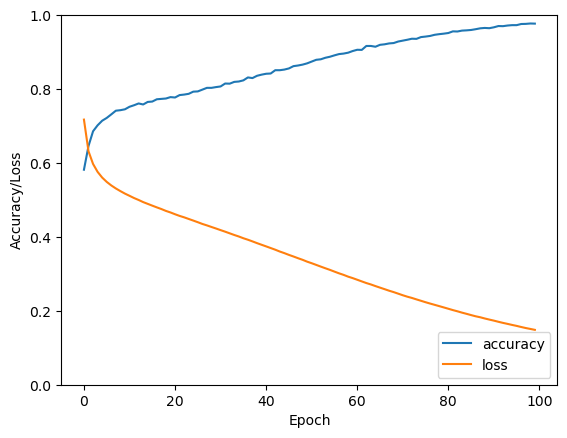

In [8]:
plt.plot(hist.history_['accuracy'], label='accuracy')
plt.plot(hist.history_['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.show()

## Result

In [9]:
y_pred_train = estimator.predict(X_train)
y_pred = estimator.predict(X_test)
y_pred_proba = estimator.predict_proba(X_test)

result = {'n Features': int(X_train.shape[1]),
        'Train Accuracy': accuracy_score(y_train, y_pred_train),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'MCC': matthews_corrcoef(y_test, y_pred), 
        'ROC': roc_auc_score(y_test, y_pred),
        'conf_mat': confusion_matrix(y_test, y_pred), 
        'prediction': y_pred,
        'predict_proba': y_pred_proba,
        'classification_report': classification_report(y_test, y_pred)}

In [10]:
pd.DataFrame([result])

,n Features,Train Accuracy,Test Accuracy,Precision,Recall,F1,MCC,ROC,conf_mat,prediction,predict_proba,classification_report
0,151,0.978365,0.712912,0.760369,0.758621,0.759494,0.403449,0.701836,"[[189, 104], [105, 330]]","[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, ...","[[0.013213873, 0.9867861], [0.75669456, 0.2433...",precision recall f1-score ...


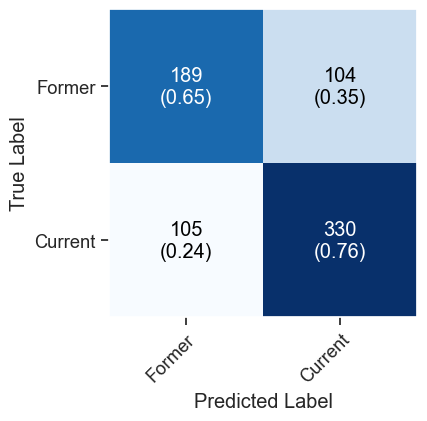

In [11]:
sns.set(font_scale=1.2, rc = {'figure.figsize':(4,4)})

fig, ax=plot_confusion_matrix(conf_mat=result['conf_mat'], show_absolute=True, 
                              show_normed=True, class_names=['Former', 'Current'])
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

**sklearn's MLP**

In [13]:
%%time
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(130), max_iter=1000,
                           activation = 'relu', solver='sgd', learning_rate_init=0.01, random_state=123)
clf.fit(X_train, y_train)

Wall time: 3.69 s


MLPClassifier(hidden_layer_sizes=130, learning_rate_init=0.01, max_iter=1000,
              random_state=123, solver='sgd')

Train Accuracy: 1.00
Test Accuracy: 0.70
Precision: 0.75
Recall: 0.74
MCC: 0.37
F1: 0.74
              precision    recall  f1-score   support

           0       0.62      0.63      0.62       293
           1       0.75      0.74      0.74       435

    accuracy                           0.70       728
   macro avg       0.68      0.68      0.68       728
weighted avg       0.70      0.70      0.70       728



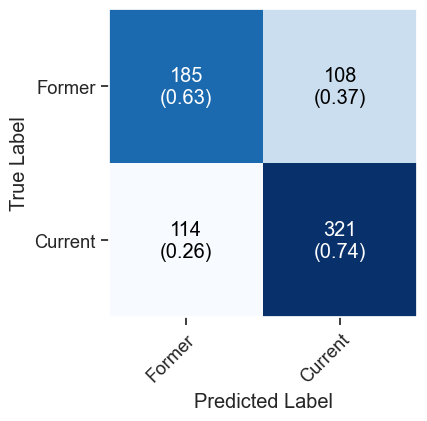

In [20]:
y_pred = clf.predict(X_test)
print("Train Accuracy: {:0.2f}".format(clf.score(X_train,y_train)))
print("Test Accuracy: {:0.2f}".format(clf.score(X_test,y_test)))
print('Precision: {:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:0.2f}'.format(recall_score(y_test, y_pred)))
print('MCC: {:0.2f}'.format(matthews_corrcoef(y_test, y_pred)))
print('F1: {:0.2f}'.format(f1_score(y_test, y_pred)))          
print(classification_report(y_test, y_pred))

fig, ax=plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred), show_absolute=True, 
                              show_normed=True, class_names=['Former', 'Current'])

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()